## Libraries

In [1]:
import rasterio as rio
import geopandas as gpd
import os
from os.path import join, expanduser
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from rasterstats import zonal_stats
from gadm import GADMDownloader
from glob import glob
import pandas as pd
from tqdm import tqdm

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format, percent_format, comma_format
import plotnine
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [3]:
import ee

In [4]:
# ee.Authenticate()

In [5]:
from gee_zonal import ZonalStats, gee_helpers

## Get boundaries

In [6]:
iso3 = "YEM"
geob1 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM1/geoBoundaries-{iso3}-ADM1.geojson")
geob2 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM2/geoBoundaries-{iso3}-ADM2.geojson")

<Axes: >

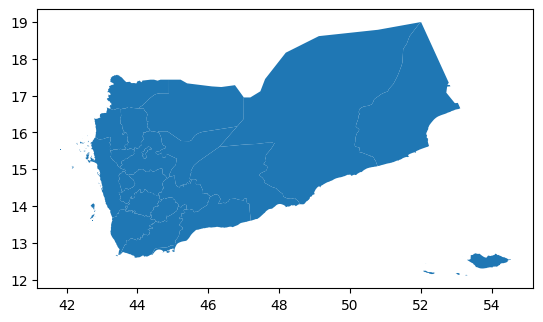

In [7]:
downloader = GADMDownloader(version="4.0")
country_name = "Yemen"
ad_level = 1
gadm1 = downloader.get_shape_data_by_country_name(country_name=country_name, ad_level=ad_level)
gadm1.plot()

In [8]:
# list(gadm1.NAME_1.unique())

In [9]:
# list(geob1.shapeName.unique())

In [10]:
# geob2.plot()

## Read NTL Data

In [11]:
data_dir = join(expanduser("~"), 'data')

In [13]:
src = rio.open(join(data_dir, 'ntl', 'yemen', 'ntl.tif'))
# src = rio.open(join(data_dir, 'ntl', 'yemen_202110.tif'))

In [14]:
src.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': nan,
 'width': 3053,
 'height': 1654,
 'count': 40,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.004166666666666666, 0.0, 41.8125,
        0.0, -0.0041666666666666675, 19.0)}

In [50]:
data = src.read(masked=True)

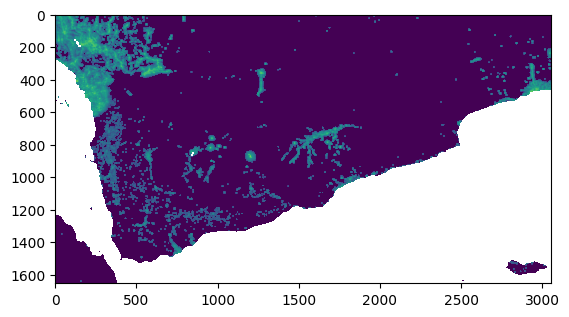

In [51]:
fig, ax = plt.subplots()
im = ax.imshow(data[0,:,:], norm=colors.PowerNorm(gamma=0.1), cmap='viridis')

In [52]:
# data[39,:,:].shape
data.shape

(40, 1654, 3053)

In [33]:
import numpy as np

In [53]:
data_sub = data[0,:,:]
data_sub = data_sub[~np.isnan(data_sub)]

In [54]:
data_sub.max()

30000.0

In [55]:
np.percentile(data_sub, 99.99)

/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.


2071.2824999997392

In [38]:
glob(join(data_dir, 'control_areas', '*.shp'))

['/home/jupyter-wb514197/data/control_areas/IRG.shp',
 '/home/jupyter-wb514197/data/control_areas/AQAP Presence.shp',
 '/home/jupyter-wb514197/data/control_areas/De-facto_authority_(DFA).shp',
 '/home/jupyter-wb514197/data/control_areas/STC.shp',
 '/home/jupyter-wb514197/data/control_areas/DFA Expanded.shp']

In [39]:
control_gdfs = [gpd.read_file(f) for f in glob(join(data_dir, 'control_areas', '*.shp'))]

In [40]:
control_gdfs[-1].set_crs('EPSG:9707', inplace=True)

,Id,geometry
0,0,"POLYGON ((45.96411 14.32770, 45.93048 14.35931..."
1,0,"POLYGON ((45.51727 14.83069, 45.48810 14.80487..."


In [41]:
[gdf.crs.to_string() for gdf in control_gdfs]

['EPSG:9707', 'EPSG:9707', 'EPSG:9707', 'EPSG:9707', 'EPSG:9707']

In [42]:
control = pd.concat(control_gdfs)

In [43]:
# control.Name.unique()

## Zonal Stats

In [44]:
gadm1.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [47]:
start = "2020-01-01"
end = "2023-05-01"
dates = pd.date_range(start=start, end=end, freq='M')

In [48]:
for date in dates:
    ym = date.strftime("%Y, %m, %d")
    print(ym)

2020, 01, 31
2020, 02, 29
2020, 03, 31
2020, 04, 30
2020, 05, 31
2020, 06, 30
2020, 07, 31
2020, 08, 31
2020, 09, 30
2020, 10, 31
2020, 11, 30
2020, 12, 31
2021, 01, 31
2021, 02, 28
2021, 03, 31
2021, 04, 30
2021, 05, 31
2021, 06, 30
2021, 07, 31
2021, 08, 31
2021, 09, 30
2021, 10, 31
2021, 11, 30
2021, 12, 31
2022, 01, 31
2022, 02, 28
2022, 03, 31
2022, 04, 30
2022, 05, 31
2022, 06, 30
2022, 07, 31
2022, 08, 31
2022, 09, 30
2022, 10, 31
2022, 11, 30
2022, 12, 31
2023, 01, 31
2023, 02, 28
2023, 03, 31
2023, 04, 30


In [56]:
res = []
for i in tqdm(range(0, src.count)):
    data_ym = data[i,:,:].copy()
    date_ym = dates[i]
    ym = date_ym.strftime("%Y%m")
    zs = pd.DataFrame(zonal_stats(gadm1, data_ym, affine=src.transform, stats='sum', nodata=src.nodata)).rename(columns = {'sum': f'rad_{ym}'})
    res.append(zs)

100%|██████████| 40/40 [00:18<00:00,  2.19it/s]


In [58]:
df = pd.concat(res, axis=1)

In [59]:
df = gadm1[['NAME_1', 'ID_1']].join(df)

In [60]:
df = pd.wide_to_long(
    df,
    stubnames = ['rad'],
    i = ['NAME_1', 'ID_1'],
    j = 'ym',
    sep = '_'
)
df

rad
NAME_1 ID_1     ym              
`Adan  YEM.1_1  202001  115144.0
                202002  113797.0
                202003   90787.0
                202004   78606.0
                202005   96613.0
...                          ...
Ta`izz YEM.21_1 202212   27036.0
                202301   29543.0
                202302   31541.0
                202303   57172.0
                202304   79298.0

[840 rows x 1 columns]

In [61]:
df.reset_index(inplace=True)

In [62]:
df.loc[:, 'ym'] = pd.to_datetime(df.ym, format="%Y%m")

In [63]:
df.head()

,NAME_1,ID_1,ym,rad
0,`Adan,YEM.1_1,2020-01-01,115144.0
1,`Adan,YEM.1_1,2020-02-01,113797.0
2,`Adan,YEM.1_1,2020-03-01,90787.0
3,`Adan,YEM.1_1,2020-04-01,78606.0
4,`Adan,YEM.1_1,2020-05-01,96613.0


In [64]:
df_filt = df.loc[df.ym>="2021-01-01"].copy()

## Plot

## EE

### Cloud Coverage

In [65]:
# coverage = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").select('cf_cvg').filterDate('2020-01-01', "2023-05-01")
coverage = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG").select('cf_cvg').filterDate('2020-01-01', "2023-05-01")


def getGT0(image):
    return image.gt(0).clip(aoi).set('system:time_start', image.get('system:time_start')) #.multiply(ee.Image.pixelArea())
def getGTE0(image):
    return image.gte(0).clip(aoi).set('system:time_start', image.get('system:time_start')) #.multiply(ee.Image.pixelArea())

aoi = gee_helpers.gpd_to_gee(gadm1)

coverage_gt0 = coverage.map(getGT0)
coverage_gte0 = coverage.map(getGTE0)

In [66]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG',
    target_features = aoi,
    statistic_type = 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = coverage_gt0
)
res = zs.runZonalStats()
# res = res.getInfo()

# df_gt0 = get_zonal_res(res)

In [67]:
df_gt0 = res.copy()

In [68]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG',
    target_features = aoi,
    statistic_type = 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = coverage_gte0
)
res = zs.runZonalStats()
# res = res.getInfo()
df_gte0 = res.copy()

In [69]:
cols_cf = ['cf' in col for col in df_gt0.columns]
cols = list(~pd.Series(cols_cf))
df_pct = df_gt0.iloc[:, cols].join(df_gt0.loc[:, cols_cf].divide(df_gte0.loc[:, cols_cf]))
def rename_func(col):
    if "cf_cvg" in col:
        p = col.split("_")
        new_name = "pct"+"__"+p[0]
        return(new_name)
    else:
        return col
df_pct.rename(rename_func, axis=1, inplace=True)
df_pct_re = pd.wide_to_long(
    df_pct,
    stubnames = ['pct'],
    i = 'NAME_1',
    j = 'date',
    sep = "__"
)
df_pct_re.reset_index(inplace=True)
df_pct_re.loc[:,"ym"] = pd.to_datetime(df_pct_re.date, format="%Y%m%d")

In [70]:
# df_pct_re

### Radiance (VIIRS EE)

In [71]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG") \
    .filterDate('2020-01-01', "2023-05-01").select('avg_rad')
#     .filterDate('2017-01-01', "2021-05-31")

In [72]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features = aoi,
    statistic_type= 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = viirs
)
res = zs.runZonalStats()

In [73]:
df_ee = res.copy()

In [74]:
df_ee.head(2)

,20200101_avg_rad,20200201_avg_rad,20200301_avg_rad,20200401_avg_rad,20200501_avg_rad,20200601_avg_rad,20200701_avg_rad,20200801_avg_rad,20200901_avg_rad,20201001_avg_rad,...,COUNTRY,ENGTYPE_1,HASC_1,ID_0,ID_1,ISO_1,NAME_1,NL_NAME_1,TYPE_1,VARNAME_1
0,8655.159786,9582.841943,7296.486551,8429.469621,8697.771651,5922.842748,6216.208877,6571.497572,6149.965611,7415.624241,...,Yemen,Governorate,YE.AD,YEM,YEM.1_1,,`Adan,عدن,Muhafazah,Aden
1,3315.778815,15509.463538,23905.897602,23683.793849,19057.799111,16566.494158,16778.273956,19150.588286,17756.389401,21237.562752,...,Yemen,Governorate,YE.AB,YEM,YEM.2_1,,Abyan,أبين,Muhafazah,


In [75]:
def rename_func(col):
    if "avg_rad" in col:
        p = col.split("_")
        if len(p)>1:
            new_name = "rad"+"__"+p[0]
            return(new_name)
        else:
            return col
    else:
        return col
df_ee.rename(rename_func, axis=1, inplace=True)
df_ee = pd.wide_to_long(
    df_ee,
    stubnames = ['rad'],
    i = 'NAME_1',
    j = 'date',
    sep = "__"
)
df_ee.reset_index(inplace=True)
df_ee.loc[:,"ym"] = pd.to_datetime(df_ee.date, format="%Y%m%d")
# df_re = df_re.loc[(df_re.date>='2019-01-01') & (df_re.date<'2021-01-01')].copy()
# df_re = df_re.loc[df_re.city!="Gumine"]
# df_re = df_re.loc[df_re.city.isin(list(sel.city))]

In [76]:
df_ee = df_ee.merge(df_pct_re[['ym','ID_1','pct']], on=['ym','ID_1'], how='outer')

In [77]:
df.columns

Index(['NAME_1', 'ID_1', 'ym', 'rad'], dtype='object')

In [78]:
df_both = df.merge(df_ee, on=['NAME_1','ID_1','ym'], how='outer', suffixes=['_bm','_eog'])

In [79]:
df_both.head()

,NAME_1,ID_1,ym,rad_bm,date,COUNTRY,ISO_1,ENGTYPE_1,NL_NAME_1,TYPE_1,VARNAME_1,HASC_1,ID_0,CC_1,rad_eog,pct
0,`Adan,YEM.1_1,2020-01-01,115144.0,20200101.0,Yemen,,Governorate,عدن,Muhafazah,Aden,YE.AD,YEM,24,8655.159786,1.0
1,`Adan,YEM.1_1,2020-02-01,113797.0,20200201.0,Yemen,,Governorate,عدن,Muhafazah,Aden,YE.AD,YEM,24,9582.841943,1.0
2,`Adan,YEM.1_1,2020-03-01,90787.0,20200301.0,Yemen,,Governorate,عدن,Muhafazah,Aden,YE.AD,YEM,24,7296.486551,1.0
3,`Adan,YEM.1_1,2020-04-01,78606.0,20200401.0,Yemen,,Governorate,عدن,Muhafazah,Aden,YE.AD,YEM,24,8429.469621,1.0
4,`Adan,YEM.1_1,2020-05-01,96613.0,20200501.0,Yemen,,Governorate,عدن,Muhafazah,Aden,YE.AD,YEM,24,8697.771651,1.0


In [80]:
df_both = df_both.loc[df_both.ym>="2022-01-01"].copy()

## Plot Both

In [81]:
one = df_both.loc[df_both.NAME_1=="Al Mahwit"].copy()
# one = df_both.loc[df_both.ID_1=="YEM.1_1"].copy()

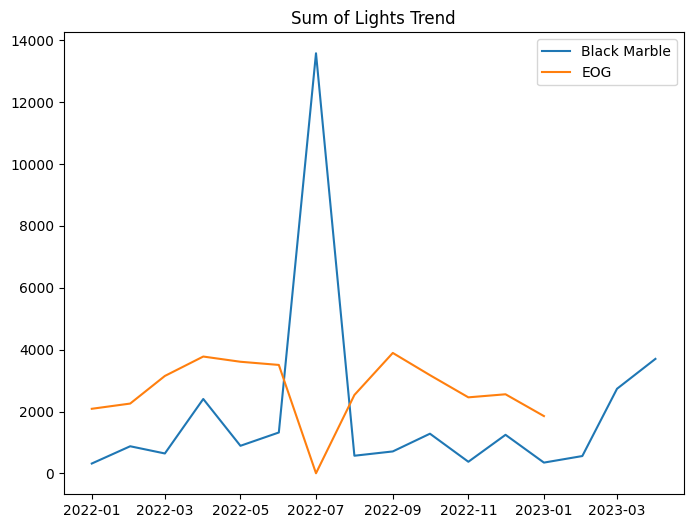

In [82]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(ax=ax, data=one, x="ym", y="rad_bm", legend=True, errorbar=None) # color='red'
sns.lineplot(ax=ax, data=one, x="ym", y="rad_eog", legend=True, errorbar=None)
ax.set(xlabel="", ylabel="", title="Sum of Lights Trend")
plt.legend(title='', loc='upper right', labels=['Black Marble', 'EOG'])
# plt.legend(title='', loc='upper right')
# plt.savefig("../docs/images/Tonga_NTL_Chart.png", facec

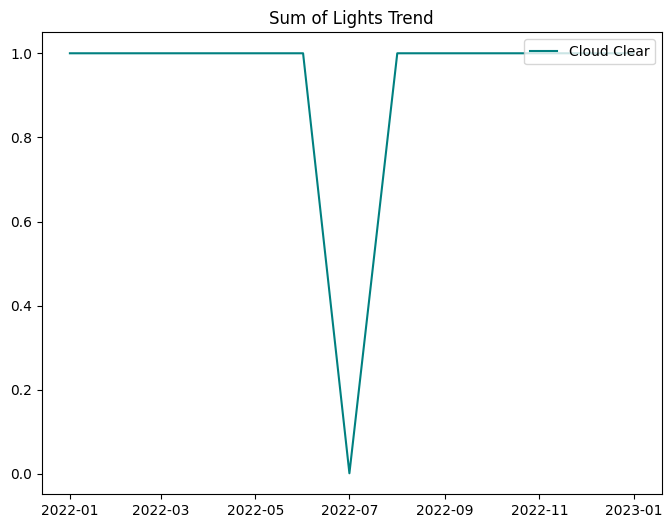

In [83]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.lineplot(data=one, x="ym", y="pct", legend=True, color='Teal') # color='red'
ax.set(xlabel="", ylabel="", title="Sum of Lights Trend")
plt.legend(title='', loc='upper right', labels=['Cloud Clear'])

# plt.legend(title='', loc='upper right')
# plt.savefig("../docs/images/Tonga_NTL_Chart.png", facec

In [84]:
date_form = DateFormatter("%Y,%m")

In [85]:
plotnine.options.figure_size = (12, 12)

In [86]:
df_both.loc[:, "newid"] = df_both.ID_1 + df_both.ym.dt.strftime("%Y%m")

In [87]:
df_both.columns

Index(['NAME_1', 'ID_1', 'ym', 'rad_bm', 'date', 'COUNTRY', 'ISO_1',
       'ENGTYPE_1', 'NL_NAME_1', 'TYPE_1', 'VARNAME_1', 'HASC_1', 'ID_0',
       'CC_1', 'rad_eog', 'pct', 'newid'],
      dtype='object')

In [89]:
df_both2 = pd.melt(
    df_both[['NAME_1', 'ym', 'rad_bm', 'rad_eog']],
    id_vars = ['NAME_1', 'ym'],
    value_vars = ['rad_bm', 'rad_eog'],
    value_name = 'rad',
    var_name = 'source'
)

In [91]:
df_both.tail(2)

,NAME_1,ID_1,ym,rad_bm,date,COUNTRY,ISO_1,ENGTYPE_1,NL_NAME_1,TYPE_1,VARNAME_1,HASC_1,ID_0,CC_1,rad_eog,pct,newid
838,Ta`izz,YEM.21_1,2023-03-01,57172.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YEM.21_1202303
839,Ta`izz,YEM.21_1,2023-04-01,79298.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YEM.21_1202304


/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 3 rows containing missing values.


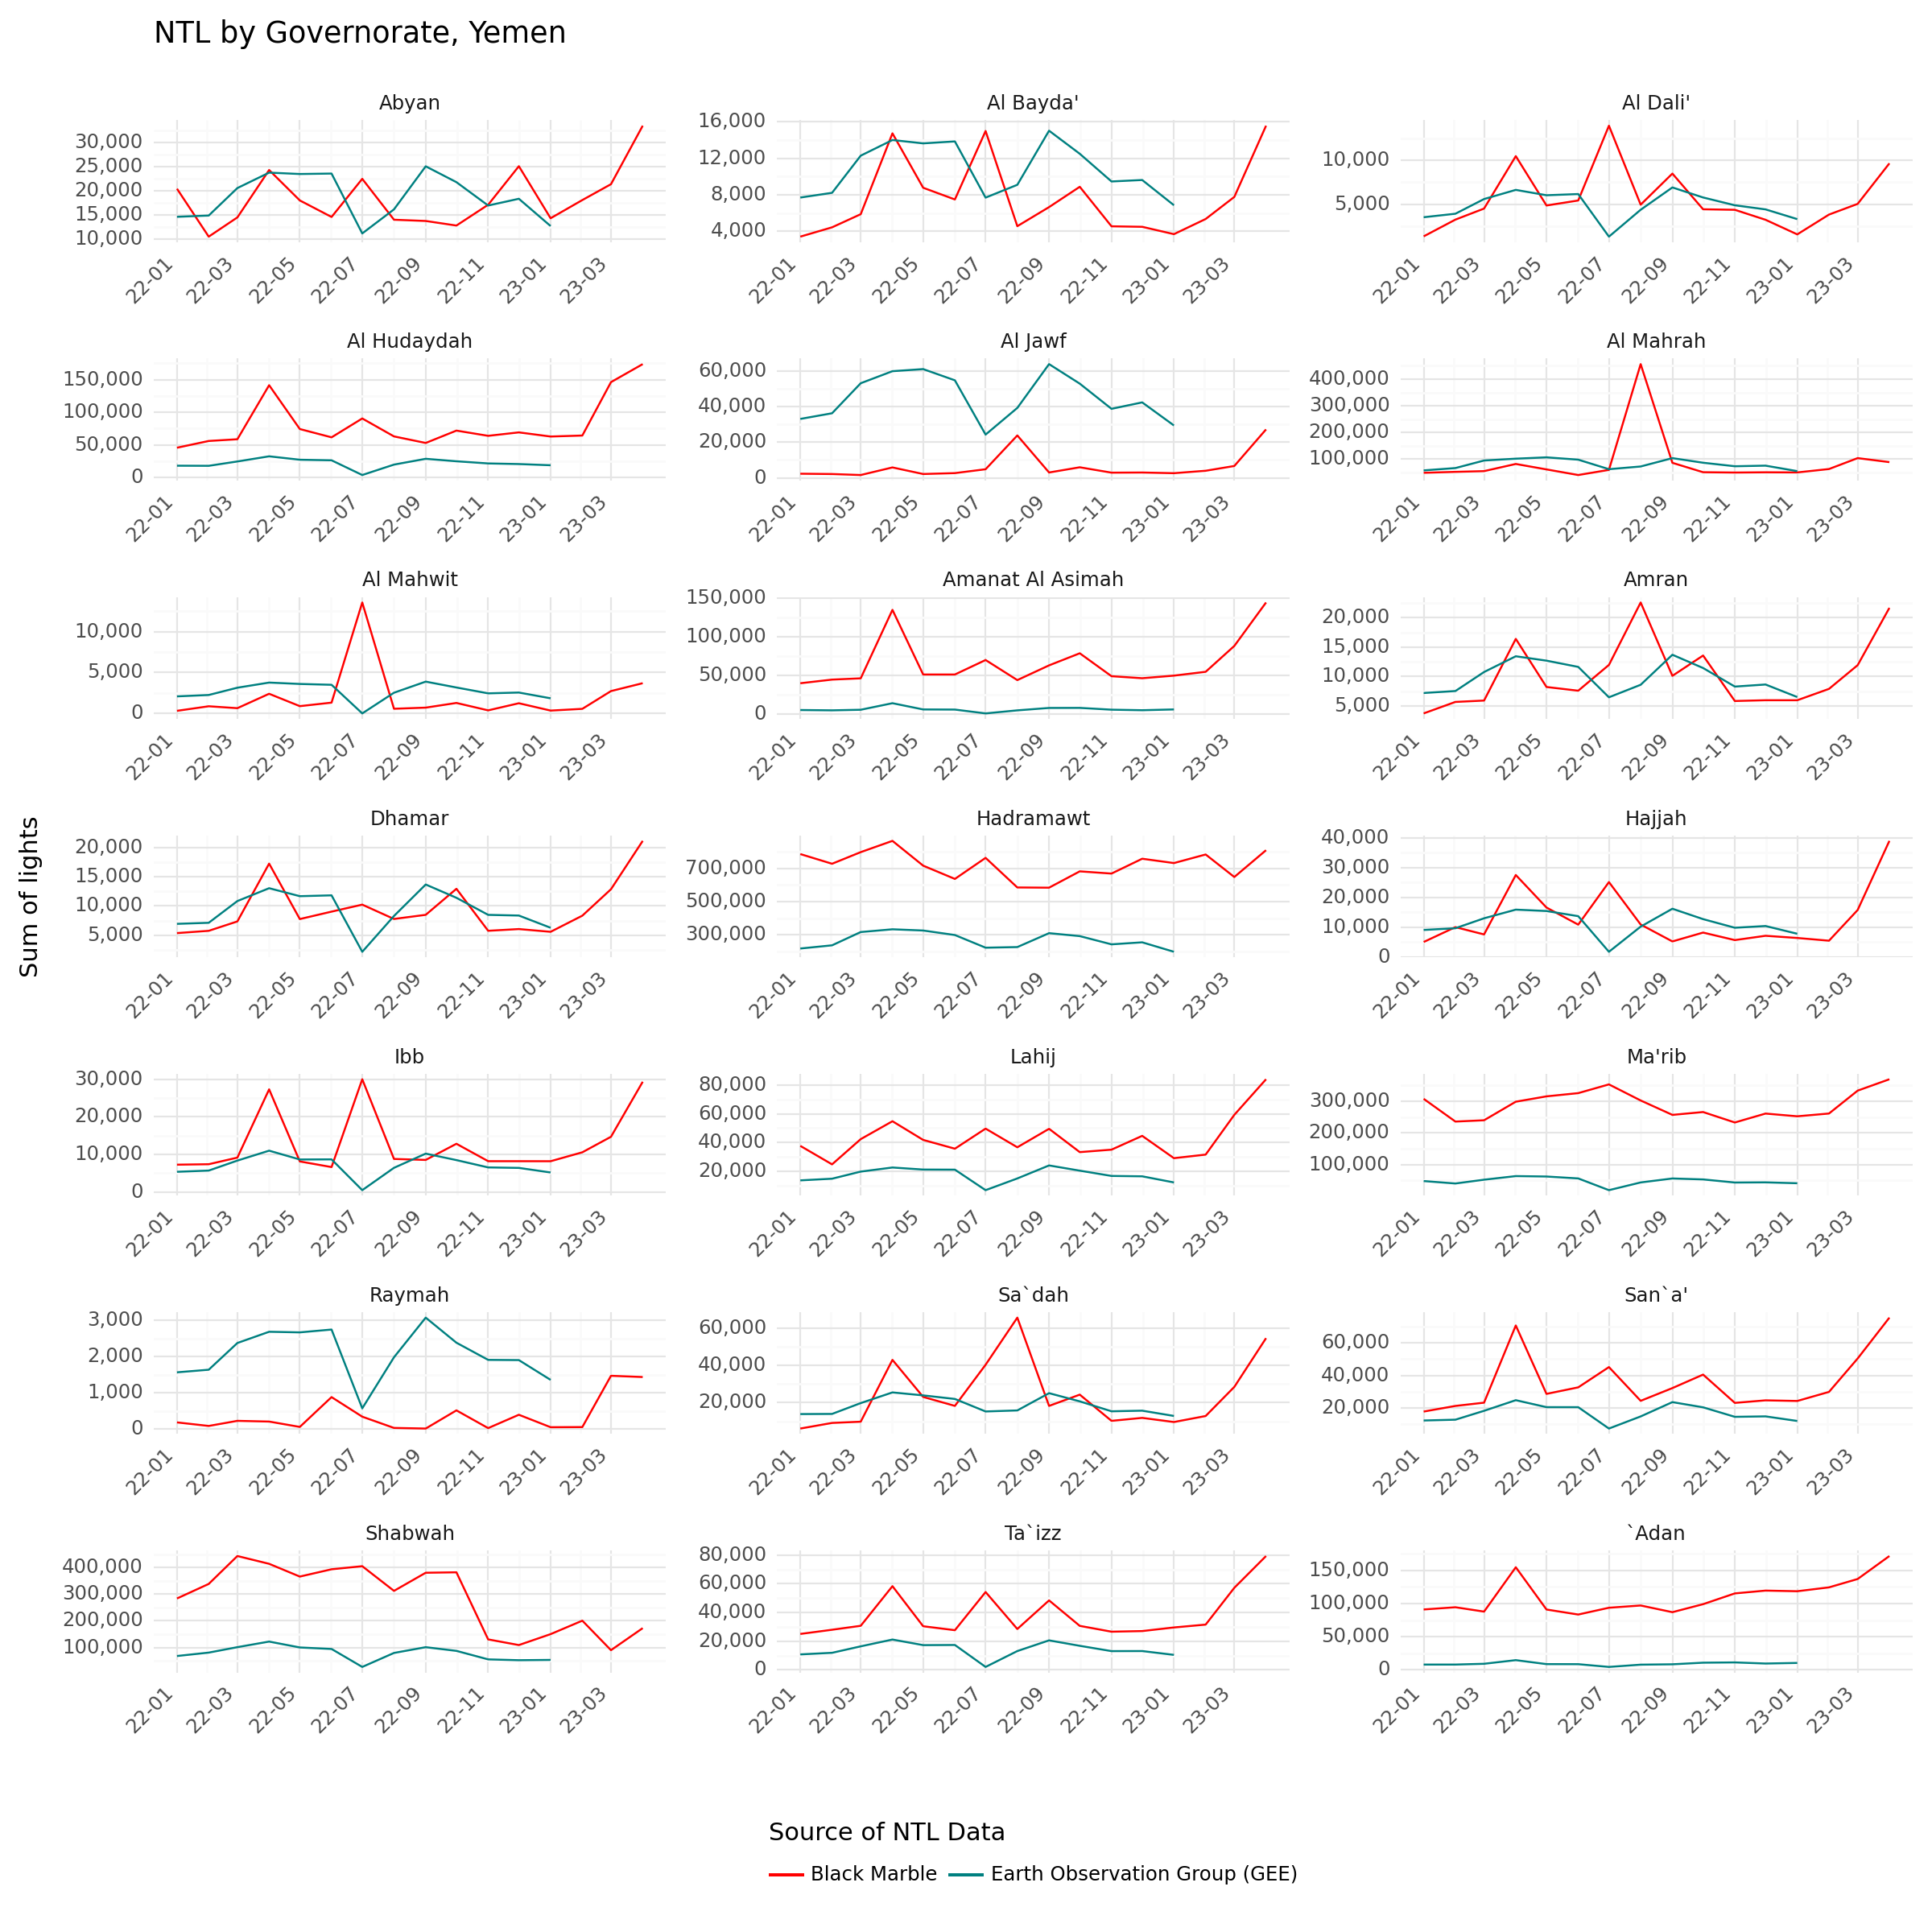

<Figure Size: (1200 x 1200)>

In [92]:
plot = (
ggplot(df_both2, aes(x="ym", y="rad", group="source", color="source")) #
    + geom_line(alpha=1)
    + labs(
        x="", y="Sum of lights", title="NTL by Governorate, Yemen",
        color="Source of NTL Data"
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('2 months'), labels=date_format('%y-%m'))
    + scale_y_continuous(labels=comma_format())
    + theme(legend_position='bottom')
    + facet_wrap("~NAME_1", scales = "free", ncol=3)
    + scale_color_manual(labels=['Black Marble', "Earth Observation Group (GEE)"], values=['red','teal'])
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
plot
# plot.save(filename='ntl_source.jpeg', dpi=300)

/home/jupyter-wb514197/.conda/envs/earth/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 3 rows containing missing values.


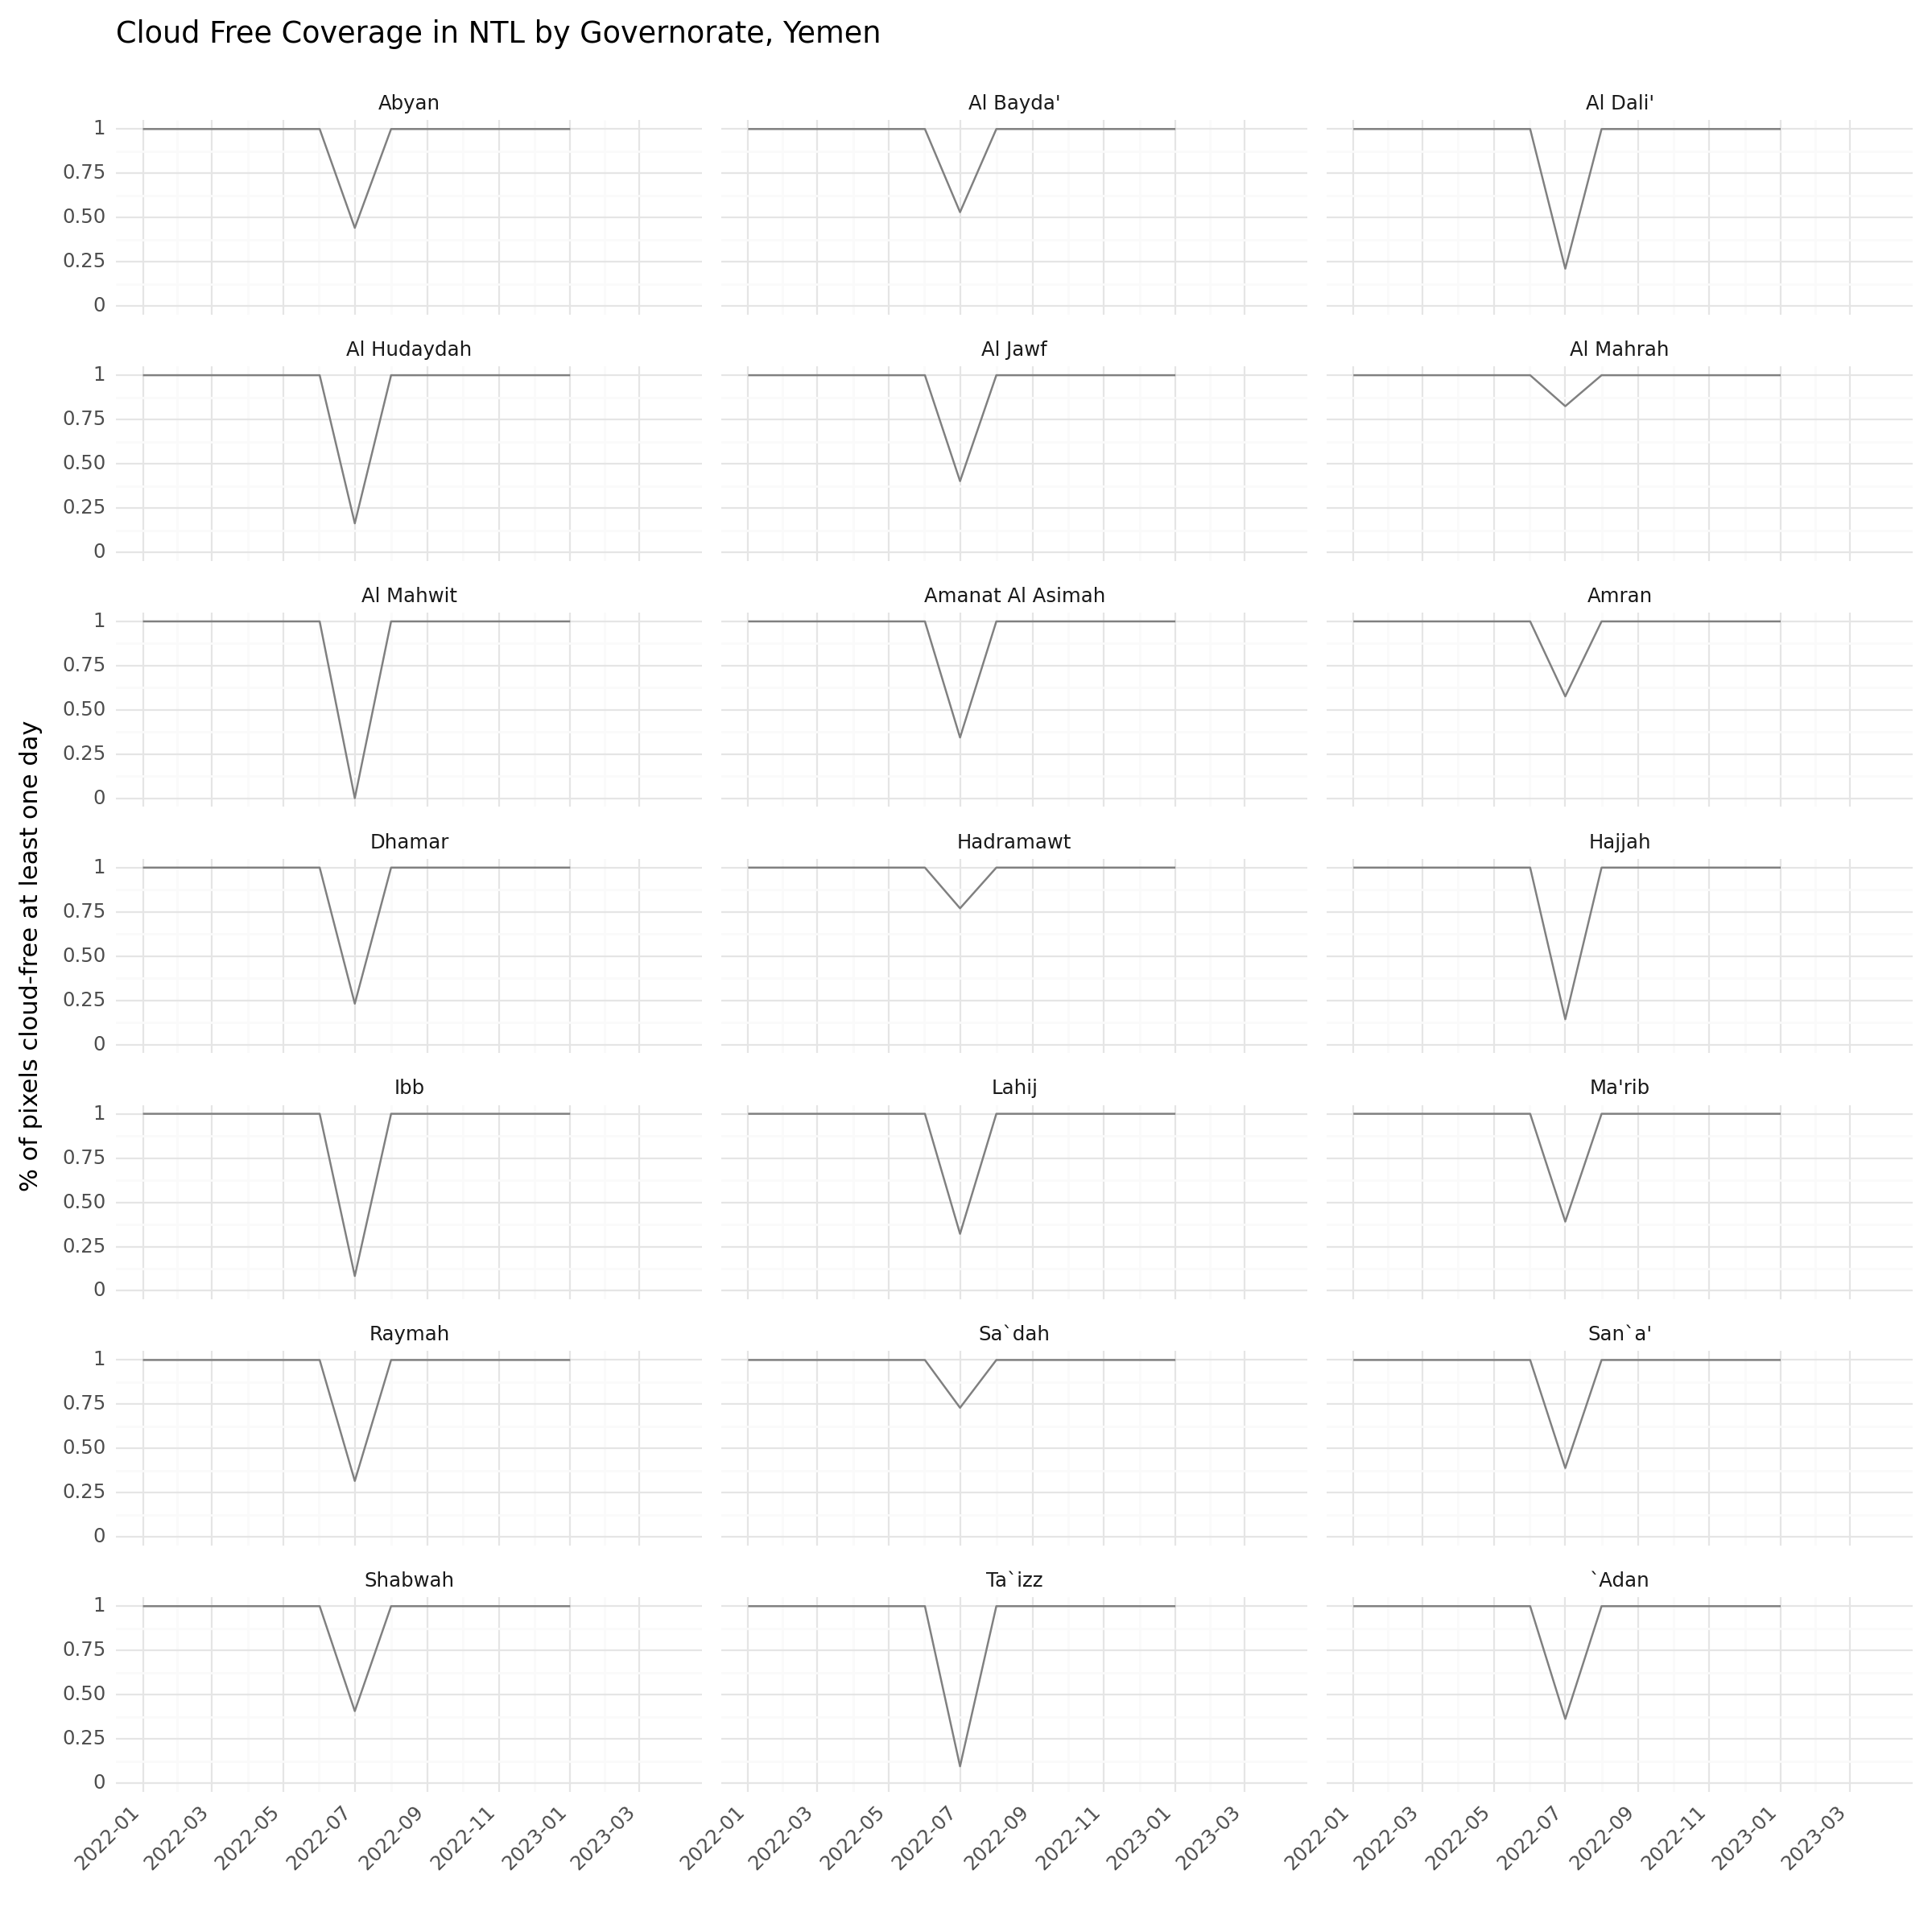

<Figure Size: (1200 x 1200)>

In [93]:
plot = (
ggplot(df_both, aes(x="ym", y="pct", group="NAME_1")) #
    + geom_line(alpha=1, color="gray")
    + labs(
        x="", y="% of pixels cloud-free at least one day", title="Cloud Free Coverage in NTL by Governorate, Yemen",
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('2 months'), labels=date_format('%Y-%m'))
    # + scale_y_continuous(labels=percent_format())
    + theme(legend_position='bottom')
    + facet_wrap("~NAME_1", scales = "fixed", ncol=3)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
plot
# plot.save(filename='cloud-free-2023.jpeg', dpi=300)